In [1]:
# Standard library imports
import os
import random
import shutil
import glob

# Third-party libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K



In [14]:
# Unified padding function
def pad_image(image, patch_size, color_mode='rgb'):
    """
    Pads an image to ensure its dimensions are divisible by the patch size.
    Args:
        image (np.array): Input image.
        patch_size (int): Size of the patches.
        color_mode (str): 'rgb' for color, 'grayscale' for single channel.
    Returns:
        np.array: Padded image.
    """
    height, width = image.shape[:2]
    channels = 1 if color_mode == 'grayscale' else 3

    pad_height = (patch_size - (height % patch_size)) % patch_size
    pad_width = (patch_size - (width % patch_size)) % patch_size

    padded_image = cv2.copyMakeBorder(
        image,
        0, pad_height, 0, pad_width,
        cv2.BORDER_CONSTANT,
        value=(0,) * channels if color_mode == 'grayscale' else (0, 0, 0)
    )
    return padded_image

# Load and preprocess images
def load_and_preprocess_image(image_path):
    """
    Loads an image and applies Gaussian blur to reduce noise.
    Args:
        image_path (str): Path to the input image.
    Returns:
        Tuple: Original image and blurred image.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return image, blurred_image

# Apply a mask to ignore the right side containing the white meter which disturbs cropping
def apply_right_side_mask(image, mask_ratio=0.1):
    """
    Applies a mask to ignore a portion of the image (e.g., a meter on the right side).
    Args:
        image (np.array): Input image.
        mask_ratio (float): Proportion of the right side to ignore.
    Returns:
        np.array: Masked image.
    """
    height, width = image.shape
    mask_width = int(width * (1 - mask_ratio))
    masked_image = image[:, :mask_width]
    return masked_image

# Find the boundaries of the Petri dish by scanning pixel values
def find_petri_dish_boundaries(image):
    """
    Finds the boundaries of the Petri dish within the image.
    Args:
        image (np.array): Input grayscale image.
    Returns:
        Tuple: (left, right, top, bottom) boundaries of the detected Petri dish.
    """
    height, width = image.shape
    left, right, top, bottom = 0, width - 1, 0, height - 1

    for x in range(width):
        if np.mean(image[:, x]) > 50:
            left = x
            break

    for x in range(width - 1, -1, -1):
        if np.mean(image[:, x]) > 50:
            right = x
            break

    for y in range(height):
        if np.mean(image[y, :]) > 50:
            top = y
            break

    for y in range(height - 1, -1, -1):
        if np.mean(image[y, :]) > 50:
            bottom = y
            break

    return left, right, top, bottom

# Crop the detected Petri dish into a square
def crop_to_square(image, boundaries):
    """
    Crops the image to a square based on the detected boundaries of the Petri dish.
    Args:
        image (np.array): Input image.
        boundaries (tuple): (left, right, top, bottom) boundaries of the Petri dish.
    Returns:
        np.array: Cropped square image.
    """
    left, right, top, bottom = boundaries
    width = right - left
    height = bottom - top
    size = min(width, height)

    left_new = left + (width - size) // 2 if width > height else left
    top_new = top + (height - size) // 2 if height > width else top

    cropped_image = image[top_new:top_new + size, left_new:left_new + size]
    return cropped_image

# Optimized patch processing function
def create_and_save_patches(dataset_type, patch_size, scaling_factor=1):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): 'train' or 'val'.
    - patch_size (int): The size of the patches.
    - scaling_factor (float): Scaling factor for resizing.
    """
    patch_dir = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_patches"
    for image_path in glob.glob(f'blood_cell_dataset/{dataset_type}_images/{dataset_type}/*.png'):
        mask_path = image_path.replace('images', 'masks')

        # Process and save image patches
        image = cv2.imread(image_path)
        image = pad_image(image, patch_size, color_mode='rgb')
        if scaling_factor != 1:
            image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 3)

        for i, patch in enumerate(patches):
            image_patch_path = f"{patch_dir}/{dataset_type}_images/{os.path.basename(image_path)[:-4]}_{i}.png"
            os.makedirs(os.path.dirname(image_patch_path), exist_ok=True)
            cv2.imwrite(image_patch_path, patch)

        # Process and save mask patches
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = pad_image(mask, patch_size, color_mode='grayscale')
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0, 0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(mask, (patch_size, patch_size, 1), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        for i, patch in enumerate(patches):
            mask_patch_path = f"{patch_dir}/{dataset_type}_masks/{os.path.basename(mask_path)[:-4]}_{i}.png"
            os.makedirs(os.path.dirname(mask_patch_path), exist_ok=True)
            cv2.imwrite(mask_patch_path, patch)

# Example usage
create_and_save_patches('train', patch_size=256, scaling_factor=1)
create_and_save_patches('val', patch_size=256, scaling_factor=1)

In [15]:
# Unified padding function
def pad_image(image, patch_size, color_mode='rgb'):
    """
    Pads an image to ensure its dimensions are divisible by the patch size.
    Args:
        image (np.array): Input image.
        patch_size (int): Size of the patches.
        color_mode (str): 'rgb' for color, 'grayscale' for single channel.
    Returns:
        np.array: Padded image.
    """
    height, width = image.shape[:2]
    channels = 1 if color_mode == 'grayscale' else 3

    pad_height = (patch_size - (height % patch_size)) % patch_size
    pad_width = (patch_size - (width % patch_size)) % patch_size

    padded_image = cv2.copyMakeBorder(
        image,
        0, pad_height, 0, pad_width,
        cv2.BORDER_CONSTANT,
        value=(0,) * channels if color_mode == 'grayscale' else (0, 0, 0)
    )
    return padded_image

# Load and preprocess images
def load_and_preprocess_image(image_path):
    """
    Loads an image and applies Gaussian blur to reduce noise.
    Args:
        image_path (str): Path to the input image.
    Returns:
        Tuple: Original image and blurred image.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return image, blurred_image


# Find the boundaries of the Petri dish by scanning pixel values
def find_petri_dish_boundaries(image):
    """
    Finds the boundaries of the Petri dish within the image.
    Args:
        image (np.array): Input grayscale image.
    Returns:
        Tuple: (left, right, top, bottom) boundaries of the detected Petri dish.
    """
    height, width = image.shape
    left, right, top, bottom = 0, width - 1, 0, height - 1

    for x in range(width):
        if np.mean(image[:, x]) > 50:
            left = x
            break

    for x in range(width - 1, -1, -1):
        if np.mean(image[:, x]) > 50:
            right = x
            break

    for y in range(height):
        if np.mean(image[y, :]) > 50:
            top = y
            break

    for y in range(height - 1, -1, -1):
        if np.mean(image[y, :]) > 50:
            bottom = y
            break

    return left, right, top, bottom


# Crop the detected Petri dish into a square
def crop_to_square(image, boundaries):
    """
    Crops the image to a square based on the detected boundaries of the Petri dish.
    Args:
        image (np.array): Input image.
        boundaries (tuple): (left, right, top, bottom) boundaries of the Petri dish.
    Returns:
        np.array: Cropped square image.
    """
    left, right, top, bottom = boundaries
    width = right - left
    height = bottom - top
    size = min(width, height)

    left_new = left + (width - size) // 2 if width > height else left
    top_new = top + (height - size) // 2 if height > width else top

    cropped_image = image[top_new:top_new + size, left_new:left_new + size]
    return cropped_image


# Optimized patch processing function
def process_and_patchify_images(input_folder, output_folder, patch_size=256, color_mode='rgb'):
    """
    Processes images, applies padding, patches them, and saves patches to the output folder.
    Args:
        input_folder (str): Path to input images.
        output_folder (str): Path to save patched images.
        patch_size (int): Size of each patch.
        color_mode (str): 'rgb' for color images, 'grayscale' for masks.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.tif')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR if color_mode == 'rgb' else cv2.IMREAD_GRAYSCALE)

            # Add channel dimension for grayscale
            if color_mode == 'grayscale' and len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)

            # Pad image
            padded_image = pad_image(image, patch_size, color_mode)

            # Add channel dimension for grayscale after padding
            if color_mode == 'grayscale' and len(padded_image.shape) == 2:
                padded_image = np.expand_dims(padded_image, axis=-1)

            # Debugging shapes
            print(f"Processing file: {filename}")
            print(f"Padded image shape: {padded_image.shape}")
            print(f"Expected window shape: {(patch_size, patch_size, 3) if color_mode == 'rgb' else (patch_size, patch_size, 1)}")

            # Patchify the image
            patches = patchify(padded_image, (patch_size, patch_size, 3) if color_mode == 'rgb' else (patch_size, patch_size, 1), step=patch_size)

            # Save patches
            for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):
                    patch = patches[i, j, 0]  # Extract the patch
                    patch_filename = f"{os.path.splitext(filename)[0]}_patch_{i}_{j}.png"
                    patch_path = os.path.join(output_folder, patch_filename)
                    cv2.imwrite(patch_path, patch)


In [ ]:
# Train and validation patch directories
train_image_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_images\train"
train_mask_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_masks\train"
train_image_patch_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_images\train_patch"
train_mask_patch_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_masks\train_patch"

# Process and patchify images
process_and_patchify_images(train_image_folder, train_image_patch_folder, patch_size=256, color_mode='rgb')
process_and_patchify_images(train_mask_folder, train_mask_patch_folder, patch_size=256, color_mode='grayscale')

# Repeat for validation
val_image_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_images\val"
val_mask_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_masks\val"
val_image_patch_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_images\val_patch"
val_mask_patch_folder = r"C:\Users\ronle\Desktop\BUAS\Y2B\Y2B_24_cleaned\output_masks\val_patch"

process_and_patchify_images(val_image_folder, val_image_patch_folder, patch_size=256, color_mode='rgb')
process_and_patchify_images(val_mask_folder, val_mask_patch_folder, patch_size=256, color_mode='grayscale')

In [2]:
# Training and validation generators
patch_dir = r'D:\Holland_Year_2\Block_B\Task5_Patches\dataset_'

# Training image generator
train_image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training mask generator
train_mask_generator = ImageDataGenerator().flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(256, 256),
    batch_size= 32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine training generators
train_generator = zip(train_image_generator, train_mask_generator)

# Validation image generator
val_image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Validation mask generator
val_mask_generator = ImageDataGenerator().flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine validation generators
val_generator = zip(val_image_generator, val_mask_generator)

Found 26015 images belonging to 1 classes.
Found 26015 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.


(256, 256, 1)


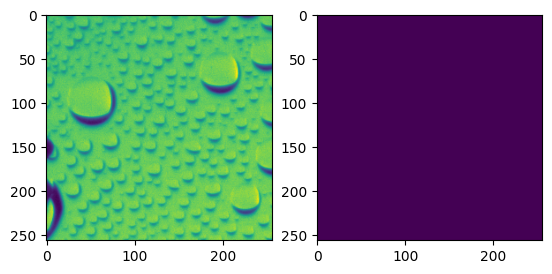

In [15]:
sample = val_generator.__next__()
fig, ax = plt.subplots(1, 2)
print(sample[0][0].shape)
ax[0].imshow(sample[0][0])
ax[1].imshow(sample[1][0])
plt.show()


(256, 256, 3)


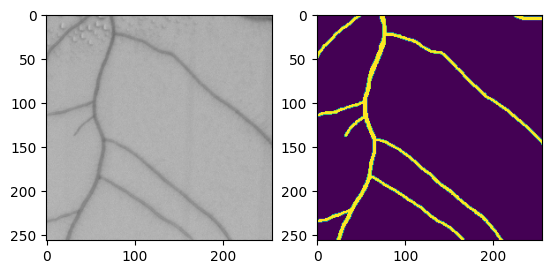

<Figure size 1500x1500 with 0 Axes>

In [17]:
sample = train_generator.__next__()
fig, ax = plt.subplots(1, 2)
print(sample[0][0].shape)
ax[0].imshow(sample[0][0])
ax[1].imshow(sample[1][0])
plt.show()

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
# Function to calculate F1 score
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [18]:
# Input size
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 1
 
# Input layer
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = inputs 
 

# Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = Model(inputs=[inputs], outputs=[outputs])
     
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
 
# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                           

In [21]:
cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'
    )

In [22]:
with tf.device('/GPU:1'):    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_image_generator),
        validation_data=val_generator,
        validation_steps=len(val_image_generator),#//16 maybe better for validation
        epochs=100,
        callbacks=[cb],
        verbose=1
)

Epoch 1/100
813/813 [==============================] - 543s 649ms/step - loss: 0.0744 - accuracy: 0.9860 - f1: 4.6973e-05 - val_loss: 0.0286 - val_accuracy: 0.9961 - val_f1: 0.0000e+00
Epoch 2/100
813/813 [==============================] - 512s 630ms/step - loss: 0.0697 - accuracy: 0.9870 - f1: 0.0000e+00 - val_loss: 0.0377 - val_accuracy: 0.9962 - val_f1: 0.0000e+00
Epoch 3/100
813/813 [==============================] - 463s 570ms/step - loss: 0.0691 - accuracy: 0.9870 - f1: 0.0000e+00 - val_loss: 0.0221 - val_accuracy: 0.9960 - val_f1: 0.0000e+00
Epoch 4/100
813/813 [==============================] - 448s 550ms/step - loss: 0.0679 - accuracy: 0.9870 - f1: 0.0027 - val_loss: 0.0226 - val_accuracy: 0.9963 - val_f1: 0.0000e+00
Epoch 5/100
813/813 [==============================] - 486s 598ms/step - loss: 0.0674 - accuracy: 0.9870 - f1: 2.5126e-05 - val_loss: 0.0255 - val_accuracy: 0.9960 - val_f1: 0.0000e+00
Epoch 6/100
813/813 [==============================] - 398s 490ms/step - loss: 

In [23]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.008159836754202843
Best validation f1: 0.8003123998641968


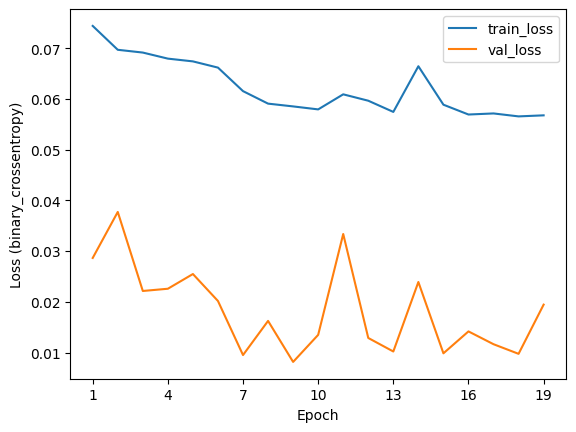

In [24]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(loss) + 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

In [25]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
model_file_name = f'PetarPaskalev_232725_unet_model_2_256px_80F1.h5'
print(model_file_name)
model.save(model_file_name)

PetarPaskalev_232725_unet_model_2_256px_80F1.h5
